# Generative Adversarial Networks (GANs) - basics

In [1]:
import sys

from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('darkgrid')

* https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
* https://github.com/soumith/ganhacks

## Generative Adversarial Nets

GANs are a framework for estimating generative models that learns to generate samples $x$ that approximate samples from a true data distribution $p_{data}(x)$ via an adversarial process which simultaneously trains two models:
* A generative model $x \sim \mathcal{G}_{\theta}(Z)$ that learns to simulate the data distribution $p_{data}(x)$ based on a latent variable $Z$ representing the noise with distribution $p_z(z)$.
* A discriminative model $\mathcal{D}_{\phi}(x)$ that estimates the probability that a sample $x$ came from the the training data rather than $\mathcal{G}$.

The training procedure for $\mathcal{G}$ is the maximize the probability of $\mathcal{D}$ making a mistake while $\mathcal{D}$ tries to distinguish between real samples $x$ and samples generated by $\mathcal{G}$. This corresponds to a minimax two-player game with value function $V(\mathcal{D}, \mathcal{G})$:

$$
\underset{\theta}{\min} \underset{\phi}{\max} 
V(\mathcal{D}_{\phi}, \mathcal{G}_{\theta})
\mathbb{E}_{x \sim p_{data}(x)} 
\left[log(\mathcal{D}_{\phi}(x) \right] + 
\mathbb{E}_{z \sim p_{z}(z)} 
\left[log(1 - \mathcal{D}_{\phi}(\mathcal{G}_{\theta}(z))) \right]
$$

In practice maximize $log(\mathcal{D}_{\phi}(\mathcal{G}_{\theta}(z)))$ to train the generator for bigger gradients in beginning of training.

A unique solution exists with $G$ recovering the training data disribution and $D$ outputting ½ everywhere.

Sources:
* [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf) (original GAN paper)

## GAN as Implicit Generative Model

In a random generative model we want to generate data samples $x \sim X$ where $p^*(x)$ is the true density function $X$. This is typically done by approximating this with a learned density function $q_{\theta}(x)$ with parameters $\theta$.

Implicit generative models are implicitly defined via a latent variable $Z \in \mathbb{R}^m$ with density function $q(z)$ that is easy to generate samples from. The latent variable $Z$ is then transformed using a parameterized deterministic function $\mathcal{G}_{\theta}: \mathbb{R}^m \mapsto \mathbb{R}^n$ with parameters $\theta$.

$$
z' \sim Z \\
x' = \mathcal{G}_{\theta}(z')
$$

With $Z$ is the external source of randomness for the generative model.
The density $q_{\theta}(x)$ of $x$ is then defined as:

$$
q_{\theta}(x) = \frac{\delta}{\delta x_1} \cdots \frac{\delta}{\delta x_d} \int_{\{\mathcal{G}_{\theta}(z)\leq x \}}q(z)dz
$$

This density $q_{\theta}(x)$ might be intractable or difficult to compute depending on $\mathcal{G}_{\theta}$. We would therefore try to learn the parameters of the model $\theta$ in a likelihood-free approach.


### Class Probability Estimation

To avoid using the likelihood we can learn the parameters $\theta$ by learning to estimate the density ratio:

$$r_{\theta} = \frac{p^*(x)}{q_{\theta}(x)}$$

We introduce a random variable $Y$ which assigns label $Y=1$ to samples from the true data distribution, and $Y=0$ to samples from the model distribution. We can write $p^*(x) = p(x \mid Y=1)$ and $q_{\theta}(x) = p(x \mid Y=0)$

We can then use Bayes formula to derive:

$$
\frac{p^*(x)}{q_{\theta}(x)}
= \frac{p(x \mid Y=1)}{(p(x \mid Y=0)}
= \frac{\frac{p(Y=1 \mid x)p(x)}{p(Y=1)}}{\frac{p(Y=0 \mid x)p(x)}{p(Y=0)}} \\
= \frac{p(Y=1 \mid x)}{p(Y=0 \mid x)} \frac{1-\pi}{\pi}
$$

With $\pi = p(Y=1)$ the marginal probability over the classes. $\pi = ½$ if the classes are balanced.

Note that now we only need to compute $p(Y=1 \mid x)$ and $p(Y=0 \mid x)$ which we can do by training a classifier to distinguish between data from the true distribution $x \sim X$ and data from the model distribution $x' \sim \mathcal{G}_{\theta}(Z)$.

This classifier is referred to as the scoring function, or descriminator $\mathcal{D}_{\phi}(x) = p(Y=1 \mid x)$ with parameters $\phi$.

If we use cross-entropy loss to optimize the discrimintor $\mathcal{D}_{\phi}$ then we get:

$$
\mathcal{L}_{\theta,\phi} = 
\mathbb{E}_{p(x \mid y)p(y)} \left[ 
-y \log \mathcal{D}_{\phi}(x) - (1-y) \log(1-\mathcal{D}_{\phi}(x)) \right] \\
= \pi \mathbb{E}_{p^*(x)}[-\log \mathcal{D}_{\phi}(x)] +
(1-\pi) \mathbb{E}_{q_{\theta}(x)}[-\log(1-\mathcal{D}_{\phi}(x))] \\
= \pi \mathbb{E}_{p^*(x)}[-\log \mathcal{D}_{\phi}(x)] +
(1-\pi) \mathbb{E}_{q_{\theta}(z)}[-\log(1-\mathcal{D}_{\phi}(\mathcal{G}_{\theta}(Z)))] 
$$

Which gives the discriminator training objective:

$$
\underset{\theta}{\min} \pi \mathbb{E}_{p^*(x)}[-\log \mathcal{D}_{\phi}(x)] + (1 - \pi) \mathbb{E}_{q_{\theta}(x)}[-\log(1 - \mathcal{D}_{\phi}(x))]
$$

And the generator training objective:

$$
\underset{\theta}{\min} \mathbb{E}_{q_{\theta}(z)}[\log(1- \mathcal{D}_{\phi}(\mathcal{G}_{\theta}(Z)))]
$$


Sources:
* [Learning in Implicit Generative Models](https://arxiv.org/abs/1610.03483) (paper)
* [Implicit Generative Models — What are you GAN-na do?](https://casmls.github.io/general/2017/05/24/ligm.html) (blogpost summary)

## More resources

* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160.pdf)
* [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
* [Understanding Generative Adversarial Networks](http://www.gatsby.ucl.ac.uk/~balaji/Understanding-GANs.pdf)
* [Towards Principled Methods for Training Generative Adversarial Networks](https://arxiv.org/abs/1701.04862)
* [Which Training Methods for GANs do actually Converge?](https://arxiv.org/abs/1801.04406)

## GAN Implementation: Learn parameters for normal distribution

samples:  torch.Size([3, 1000])


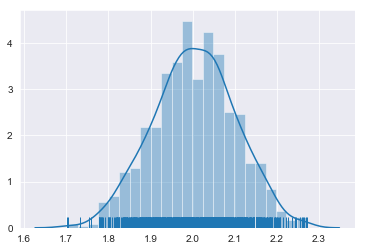

In [2]:
class NormalSamplesDataset(Dataset):
    def __init__(self, mean, std, sample_size, nb_samples):
        self.mean = mean
        self.std = std
        self.sample_size = sample_size
        self.nb_samples = nb_samples

    def __getitem__(self, index):
        return np.random.normal(
            loc=self.mean,
            scale=self.std,
            size=self.sample_size).astype(np.float32)

    def __len__(self):
        return self.nb_samples


dataset = NormalSamplesDataset(
    mean=2, std=0.1, sample_size=1000, nb_samples=3)
dataloader = DataLoader(
    dataset, batch_size=3, shuffle=False)

samples = next(iter(dataloader))
print('samples: ', samples.shape)
sns.distplot(samples[0], kde=True, rug=True)
plt.show()

In [3]:
def gen_noise(batch_size, sample_size):
    z = np.random.normal(
        loc=0.,
        scale=1.,
        size=(batch_size, sample_size)).astype(np.float32)
    return torch.tensor(z, requires_grad=False)


noise = gen_noise(2, 10)
print('noise: ', noise.size())

noise:  torch.Size([2, 10])


Generator()
parameters:  [Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]
samples:  torch.Size([3, 1000])


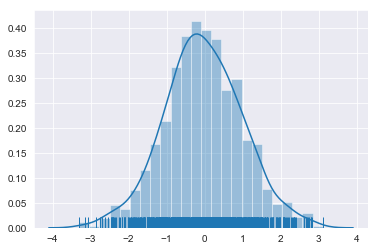

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.mean = nn.Parameter(
            torch.zeros(size=(1,), requires_grad=True))
        self.std_before_pos = nn.Parameter(
            torch.zeros(size=(1,), requires_grad=True))
        
    @property
    def std(self):
        return torch.exp(self.std_before_pos)
    
    def forward(self, z):
        return self.std * z + self.mean

    
generator = Generator()
print(generator)
print('parameters: ', list(generator.parameters()))
z = gen_noise(3, 1000)
samples = generator(z)
print('samples: ', samples.shape)
sns.distplot(samples[0].detach().numpy(), kde=True, rug=True)
plt.show()

In [5]:
def kl(mu_1, sigma_1, mu_2, sigma_2):
    """KL(p,q) p:(mu_1, sigma_1) q:(mu_2, sigma_2)"""
    return (
        torch.log(sigma_2 / sigma_1) +
        ((sigma_1**2 + (mu_1 - mu_2)**2) / (2*sigma_2**2)) - 
        (1 / 2)
    )

def jenssen_divergence(mu_1, sigma_1, mu_2, sigma_2):
    return (
        0.5 * kl(mu_1, sigma_1, mu_2, sigma_2) +
        0.5 * kl(mu_2, sigma_2, mu_1, sigma_1))

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu = nn.Parameter(
            torch.zeros(size=(1,), requires_grad=True))
        self._before_sigma = nn.Parameter(
            torch.zeros(size=(1,), requires_grad=True))
        self.logits = nn.Linear(1, 1, bias=True)
        self.sigmoid_out = nn.Sigmoid()
        
    @property
    def sigma(self):
        return torch.exp(self._before_sigma)
        
    def forward(self, x):
        mu_x = torch.mean(x, dim=1, keepdim=True)
        sigma_x = torch.std(x, dim=1, keepdim=True)
        jd = jenssen_divergence(mu_x, sigma_x, self.mu, self.sigma)
        return self.sigmoid_out(self.logits(jd))
        

discriminator = Discriminator()
print('discriminator: ', discriminator)
print('parameters: ', list(generator.parameters()))


samples = generator(gen_noise(2, 1000))
print('samples: ', samples.shape)
output =  discriminator(samples)
print('output: ', output.size())

discriminator:  Discriminator(
  (logits): Linear(in_features=1, out_features=1, bias=True)
  (sigmoid_out): Sigmoid()
)
parameters:  [Parameter containing:
tensor([0.], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]
samples:  torch.Size([2, 1000])
output:  torch.Size([2, 1])


In [7]:
def test(discriminator, generator, test_loader):
    with torch.no_grad():
        nb_total = 0.
        nb_correct = 0.
        for x_real in test_loader:
            batch_size = x_real.size(0)
            sample_size = x_real.size(1)
            x_gen = generator(gen_noise(batch_size, sample_size))
            pred_real = discriminator(x_real)
            nb_correct += (pred_real > 0.5).sum().item()
            nb_total += batch_size
            pred_fake = discriminator(x_gen)
            nb_correct += (pred_fake < 0.5).sum().item()
            nb_total += batch_size
    return nb_correct / nb_total
            
test_loader = dataloader = DataLoader(
    NormalSamplesDataset(
        mean=2, std=0.1, sample_size=10, nb_samples=3), 
    batch_size=3, shuffle=False)
acc = test(discriminator, generator, test_loader)
print('accuracy: ', acc)

accuracy:  1.0


In [8]:
del dataset, dataloader
del noise
del samples, output
del discriminator, generator
del acc, test_loader

## Training

In [9]:
def train_gan(
        generator,
        discriminator,
        x_real,
        optimizer_gen,
        optimizer_discr,
        loss_fn):
    batch_size = x_real.size(0)
    sample_size = x_real.size(1)
    # Train generator
    optimizer_gen.zero_grad()
    x_gen = generator(gen_noise(batch_size, sample_size))
    pred_gen = discriminator(x_gen)
    loss_gen = loss_fn(
        input=pred_gen, 
        target=torch.ones(batch_size, 1))
    loss_gen.backward()
    optimizer_gen.step()
    # Train discriminator
    optimizer_discr.zero_grad()
    # Discriminator real
    pred_real = discriminator(x_real)
    loss_discr = loss_fn(
        input=pred_real, 
        target=torch.ones(batch_size, 1)) * 0.5
    # Train discrimintoror
    pred_gen = discriminator(x_gen.detach())
    loss_discr += loss_fn(
        input=pred_gen, 
        target=torch.zeros(batch_size, 1)) * 0.5
    loss_discr.backward()
    optimizer_discr.step()
    return loss_discr.detach().cpu().item(), loss_gen.detach().cpu().item()

In [10]:
mean = 0.5
std = 0.87
sample_size = 9
batch_size = 32
nb_samples = batch_size * 10
nb_epochs = 250


train_dataset = NormalSamplesDataset(
    mean=mean, std=std, 
    sample_size=sample_size, nb_samples=nb_samples)
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False)

print('train_dataloader: ', len(train_dataloader))

samples = next(iter(train_dataloader))
print('samples: ', samples.shape)

train_dataloader:  10
samples:  torch.Size([32, 9])


In [11]:
test_dataset = NormalSamplesDataset(
    mean=mean, std=std, 
    sample_size=sample_size, nb_samples=nb_samples)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

print('test_dataloader: ', len(test_dataloader))

test_dataloader:  10


In [12]:
discriminator = Discriminator()
print('discriminator: ', discriminator)
generator = Generator()
print('generator: ', generator)

optimizer_discr = optim.Adam(discriminator.parameters(), lr=0.01)
scheduler_discr = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_discr, T_max=nb_epochs)
optimizer_gen = optim.Adam(generator.parameters(), lr=0.02)
scheduler_gen = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_gen, T_max=nb_epochs)

loss_fn = nn.BCELoss()

discriminator:  Discriminator(
  (logits): Linear(in_features=1, out_features=1, bias=True)
  (sigmoid_out): Sigmoid()
)
generator:  Generator()


In [13]:
nb_train_batches = len(train_dataloader)
print('nb_train_batches: ', nb_train_batches)

gen_losses = []
discr_losses = []
test_accs = []

with tqdm(total=nb_epochs, file=sys.stdout) as pbar:
    for epoch in range(nb_epochs):
        for i, samples_real in enumerate(train_dataloader):
            discr_loss, gen_loss = train_gan(
                generator,
                discriminator,
                samples_real,
                optimizer_gen,
                optimizer_discr,
                loss_fn)
            batch_idx = epoch + (i / nb_train_batches)
            discr_losses.append((batch_idx, discr_loss))
            gen_losses.append((batch_idx, gen_loss))
            scheduler_discr.step()
            scheduler_gen.step()
        acc = test(discriminator, generator, test_dataloader)
        test_accs.append((epoch, acc))
        pbar.update(1)

nb_train_batches:  10
100%|██████████| 250/250 [00:09<00:00, 26.15it/s]


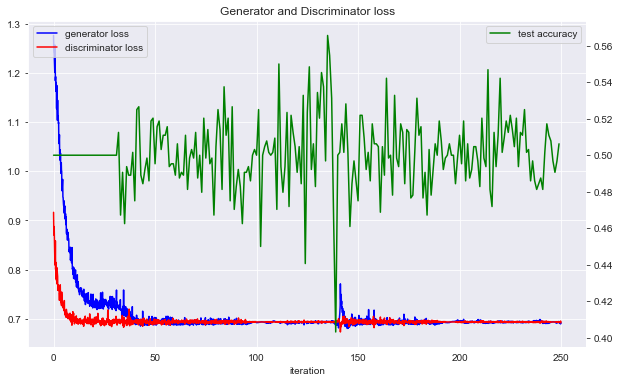

In [14]:
# Plot training graphs
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
ax1.set_xlabel('iteration')
ax1.set_title('Generator and Discriminator loss')
ax1.plot(*zip(*gen_losses), 'b-', label='generator loss')
ax1.plot(*zip(*discr_losses), 'r-', label='discriminator loss')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.grid(False)
ax2.plot(*zip(*test_accs), 'g-', label='test accuracy')
ax2.legend(loc='upper right')
plt.show()

In [15]:
print('Real mean: ', mean)
print('Real std: ', std)
print('Generator params:')
print('generator.mean: ', generator.mean.item())
print('generator.std: ', generator.std.item())
print('Discriminator params:')
print('discriminator.mu: ', discriminator.mu.item())
print('discriminator.sigma: ', discriminator.sigma.item())

Real mean:  0.5
Real std:  0.87
Generator params:
generator.mean:  0.5314913988113403
generator.std:  0.8512625694274902
Discriminator params:
discriminator.mu:  0.5107253193855286
discriminator.sigma:  0.8137916922569275
